# Predicting Bankruptcy in Poland

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import gzip
import pickle
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)


## Prepare Data

### Open


In [4]:
# Open compressed file, load into dictionary
with gzip.open("data/poland-bankruptcy-data-2009.json.gz", "r") as f:
    poland_data = json.load(f)
    
print(type(poland_data))

<class 'dict'>


### Explore

In [5]:
# get keys of JSON file
poland_data.keys()

dict_keys(['schema', 'data', 'metadata'])

In [6]:
# get information about the data
poland_data['metadata']

{'title': 'Ensemble Boosted Trees with Synthetic Features Generation in Application to Bankruptcy Prediction',
 'authors': 'Zieba, M., Tomczak, S. K., & Tomczak, J. M.',
 'journal': 'Expert Systems with Applications',
 'publicationYear': 2016,
 'dataYear': 2009,
 'articleLink': 'doi:10.1016/j.eswa.2016.04.001',
 'datasetLink': 'https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data'}

In [7]:
# print schema 
poland_data['schema']

{'fields': [{'name': 'company_id', 'type': 'integer'},
  {'name': 'feat_1', 'type': 'number'},
  {'name': 'feat_2', 'type': 'number'},
  {'name': 'feat_3', 'type': 'number'},
  {'name': 'feat_4', 'type': 'number'},
  {'name': 'feat_5', 'type': 'number'},
  {'name': 'feat_6', 'type': 'number'},
  {'name': 'feat_7', 'type': 'number'},
  {'name': 'feat_8', 'type': 'number'},
  {'name': 'feat_9', 'type': 'number'},
  {'name': 'feat_10', 'type': 'number'},
  {'name': 'feat_11', 'type': 'number'},
  {'name': 'feat_12', 'type': 'number'},
  {'name': 'feat_13', 'type': 'number'},
  {'name': 'feat_14', 'type': 'number'},
  {'name': 'feat_15', 'type': 'number'},
  {'name': 'feat_16', 'type': 'number'},
  {'name': 'feat_17', 'type': 'number'},
  {'name': 'feat_18', 'type': 'number'},
  {'name': 'feat_19', 'type': 'number'},
  {'name': 'feat_20', 'type': 'number'},
  {'name': 'feat_21', 'type': 'number'},
  {'name': 'feat_22', 'type': 'number'},
  {'name': 'feat_23', 'type': 'number'},
  {'name': 

In [8]:
# get financial data of the first company
poland_data['data'][0]

{'company_id': 1,
 'feat_1': 0.17419,
 'feat_2': 0.41299,
 'feat_3': 0.14371,
 'feat_4': 1.348,
 'feat_5': -28.982,
 'feat_6': 0.60383,
 'feat_7': 0.21946,
 'feat_8': 1.1225,
 'feat_9': 1.1961,
 'feat_10': 0.46359,
 'feat_11': 0.21946,
 'feat_12': 0.53139,
 'feat_13': 0.14233,
 'feat_14': 0.21946,
 'feat_15': 592.24,
 'feat_16': 0.6163,
 'feat_17': 2.4213,
 'feat_18': 0.21946,
 'feat_19': 0.12272,
 'feat_20': 37.573,
 'feat_21': 0.9969,
 'feat_22': 0.2951,
 'feat_23': 0.097402,
 'feat_24': 0.75641,
 'feat_25': 0.46359,
 'feat_26': 0.50669,
 'feat_27': 1.9737,
 'feat_28': 0.32417,
 'feat_29': 5.9473,
 'feat_30': 0.22493,
 'feat_31': 0.12272,
 'feat_32': 100.82,
 'feat_33': 3.6203,
 'feat_34': 0.71453,
 'feat_35': 0.2951,
 'feat_36': 1.8079,
 'feat_37': 123140.0,
 'feat_38': 0.46359,
 'feat_39': 0.16501,
 'feat_40': 0.21282,
 'feat_41': 0.041124,
 'feat_42': 0.16501,
 'feat_43': 95.682,
 'feat_44': 58.109,
 'feat_45': 0.94621,
 'feat_46': 0.90221,
 'feat_47': 44.941,
 'feat_48': 0.26003,

In [9]:
# calculate number of companies
print(f"There are {len(poland_data['data'])} companies in the dataset")

There are 9977 companies in the dataset


In [10]:
# calculate number of features
print(f"Each company has {len(poland_data['data'][0])} attributes")

Each company has 66 attributes


### Import

In [11]:
# define data wrangling function
def wrangle(filepath):
    
    # Open compressed file, load into dictionary
    with gzip.open(filepath, "r") as file:
        data = json.load(file)
        
    # Load dictionary into DataFrame, set index
    df = pd.DataFrame().from_dict(data['data']).set_index('company_id')

    return df

In [12]:
# print data
df = wrangle("data/poland-bankruptcy-data-2009.json.gz")
print(df.shape)
df.head()

(9977, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
1,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.12250,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,False
2,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.17210,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,False
3,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.98810,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,False
5,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.40940,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,False
6,0.182060,0.55615,0.32191,1.6045,16.3140,0.00000,0.182060,0.79808,1.8126,0.44385,...,0.555770,0.410190,0.46957,0.029421,8.4553,3.3488,107.240,3.4036,12.4540,False


### Explore More

In [13]:
# inspect dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9977 entries, 1 to 10503
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feat_1    9977 non-null   float64
 1   feat_2    9977 non-null   float64
 2   feat_3    9977 non-null   float64
 3   feat_4    9960 non-null   float64
 4   feat_5    9952 non-null   float64
 5   feat_6    9977 non-null   float64
 6   feat_7    9977 non-null   float64
 7   feat_8    9964 non-null   float64
 8   feat_9    9974 non-null   float64
 9   feat_10   9977 non-null   float64
 10  feat_11   9977 non-null   float64
 11  feat_12   9960 non-null   float64
 12  feat_13   9935 non-null   float64
 13  feat_14   9977 non-null   float64
 14  feat_15   9970 non-null   float64
 15  feat_16   9964 non-null   float64
 16  feat_17   9964 non-null   float64
 17  feat_18   9977 non-null   float64
 18  feat_19   9935 non-null   float64
 19  feat_20   9935 non-null   float64
 20  feat_21   9205 non-null   flo

In [14]:
# calculate nulls in each column
nans_by_col = df.isnull().sum()
print("nans_by_col shape:", nans_by_col.shape)
nans_by_col.head()

nans_by_col shape: (65,)


feat_1     0
feat_2     0
feat_3     0
feat_4    17
feat_5    25
dtype: int64

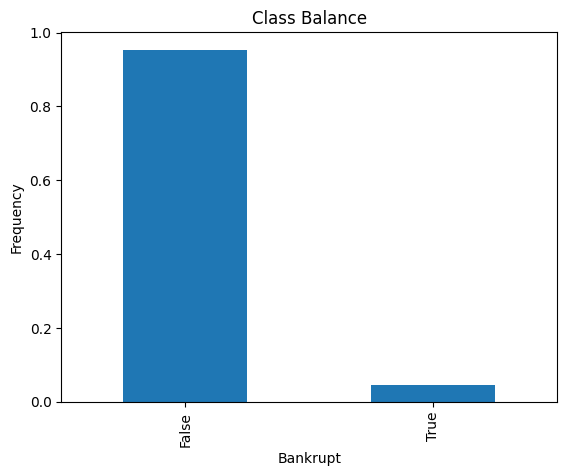

In [15]:
# plot class balance
df['bankrupt'].value_counts(normalize=True).plot(
    kind="bar",
    xlabel= "Bankrupt",
    ylabel="Frequency",
    title="Class Balance"
);

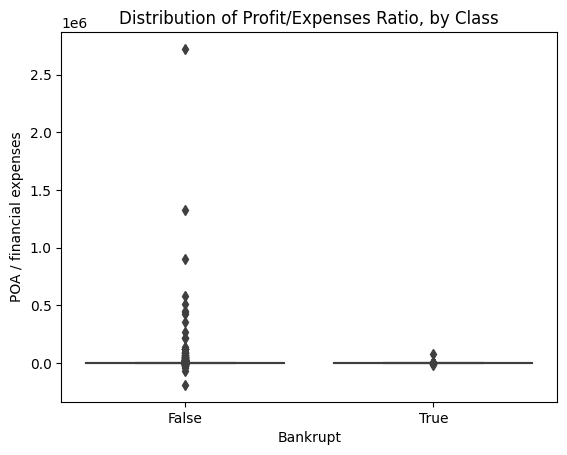

In [16]:
# Create boxplot
sns.boxplot(x="bankrupt", y="feat_27", data=df)
plt.xlabel("Bankrupt")
plt.ylabel("POA / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Class");

In [17]:
# Summary statistics for `feat_27`
df['feat_27'].describe().apply("{0:,.0f}".format)

count        9,312
mean         1,206
std         35,477
min       -190,130
25%              0
50%              1
75%              5
max      2,723,000
Name: feat_27, dtype: object

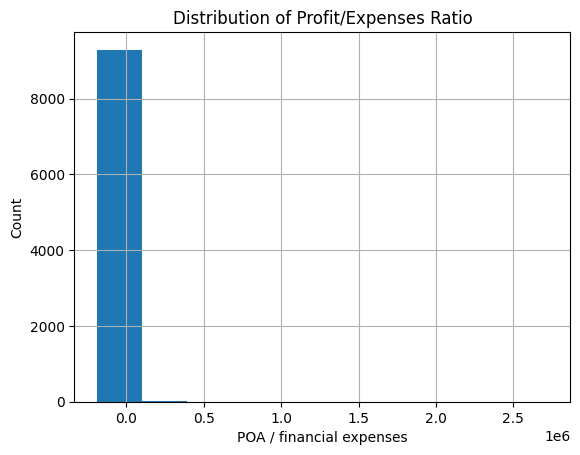

In [18]:
# Plot histogram of `feat_27`
df["feat_27"].hist()
plt.xlabel("POA / financial expenses")
plt.ylabel("Count"),
plt.title("Distribution of Profit/Expenses Ratio");

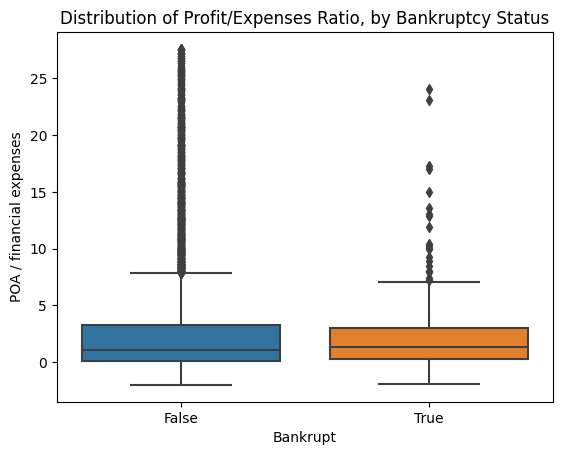

In [19]:
# Create clipped boxplot
q1,q9 = df["feat_27"].quantile([0.1,0.9])
mask = df["feat_27"].between(q1,q9)
sns.boxplot(x="bankrupt", y="feat_27", data=df[mask])
plt.xlabel("Bankrupt")
plt.ylabel("POA / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Bankruptcy Status");

### Split

In [14]:
# assign target variable
target = "bankrupt"

# perform vertical split
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9977, 64)
y shape: (9977,)


In [15]:
# perform horizontal split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7981, 64)
y_train shape: (7981,)
X_test shape: (1996, 64)
y_test shape: (1996,)


In [16]:
# create training and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (6384, 64)
y_train shape: (6384,)
X_val shape: (1597, 64)
y_val shape: (1597,)


### Resample


#### Random Under-sampling

In [17]:
# initialize randomundersampler object
under_sampler = RandomUnderSampler(random_state = 42)
# create undersampled training data
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
print(X_train_under.shape)
X_train_under.head()

(614, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,-0.048528,0.54436,-0.035831,0.93407,-85.016,0.101070,-0.076917,0.79425,1.05350,0.43236,...,-2555.5,0.050750,-0.112240,0.94925,0.002140,17.3620,6.7795,134.850,2.70670,2.98720
1,0.484910,0.35377,0.299150,1.98970,46.321,0.000000,0.484910,1.82670,1.97710,0.64623,...,1154.5,0.251150,0.750380,0.75599,0.060785,24.3650,4.1618,55.803,6.54090,4.96040
2,0.027151,0.67266,-0.179270,0.66323,-158.040,0.045962,0.037442,0.48663,1.09640,0.32734,...,-7536.2,0.087917,0.082944,0.91208,0.428750,4.9004,8.7207,179.850,2.02940,1.66980
3,0.064845,0.19322,0.157910,2.39170,64.879,0.000000,0.064845,4.17560,0.67095,0.80678,...,1260.1,0.472680,0.080374,0.56136,0.097595,202.7500,4.1625,61.724,5.91340,0.92084
4,-0.011626,0.56326,0.290910,1.74970,-50.682,-0.011626,-0.002733,0.64785,1.01140,0.36491,...,24931.0,0.011285,-0.031859,0.98871,0.480240,1.1494,1.0735,391.910,0.93134,1.12550


In [18]:
# check if data is balanced
y_train_under.value_counts(normalize=True)

False    0.5
True     0.5
Name: bankrupt, dtype: float64

#### Random Over-sampling

In [19]:
# Initialize oversampler object
over_sampler = RandomOverSampler(random_state=42)
# create oversampled training data
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(X_train_over.shape)
X_train_over.head()

(12154, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.729340,0.52182,0.367880,1.70500,9.1163,2.644000e-07,0.906580,0.91635,5.3070,0.47818,...,1391.50,0.181610,1.525300,0.82920,0.0000,20.6730,10.0910,35.889,10.1700,48.1150
1,0.085838,0.64143,0.025894,1.06480,-61.1180,2.871900e-01,0.111450,0.54599,1.1614,0.35022,...,752.78,0.139000,0.245100,0.86100,0.6908,6.4938,7.1484,131.090,2.7844,1.9359
2,0.164050,0.74380,-0.319370,0.49720,-150.2300,1.471400e-01,0.207510,0.34041,1.2311,0.25320,...,-15980.00,0.187730,0.647940,0.81227,0.4290,8.0376,13.9680,147.180,2.4800,2.3024
3,0.054298,0.51671,0.261350,1.51070,-26.2110,0.000000e+00,0.067057,0.93534,1.9411,0.48329,...,212.35,0.034188,0.112350,0.96551,0.0000,4.9037,7.4610,96.221,3.7933,8.5539
4,0.000836,0.63991,-0.040320,0.90768,-43.4850,-1.422900e-02,0.016359,0.56271,1.7371,0.36009,...,-1914.00,0.047134,0.002321,0.99045,0.4564,13.2200,8.3677,91.774,3.9772,2.8780


In [20]:
# check if data is balanced
y_train_over.value_counts(normalize=True)

False    0.5
True     0.5
Name: bankrupt, dtype: float64

## Build Model

### Baseline

In [21]:
# determine baseline accuracy
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9519


### Iterate

#### Imputer

In [22]:
# create numerical processor for tree models
num_tree_processor = SimpleImputer()


#### The Models



In [23]:
# instantiate linear regression model
dt_model = DecisionTreeClassifier(random_state=42)
# instantiate random forrest model
rf_model = RandomForestClassifier(random_state=42)
# instantiate gradient boosting model
gbdt_model = GradientBoostingClassifier(random_state=42)

#### Pipelines

In [24]:
# create pipeline for decision tree model
dt_pipeline = make_pipeline(num_tree_processor, dt_model)
# display pipeline
dt_pipeline


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [25]:
# create pipeline for random forest model
rf_pipeline = make_pipeline(num_tree_processor, rf_model)
# display pipeline
rf_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [26]:
# create pipeline for random forest model
gbdt_pipeline = make_pipeline(num_tree_processor, gbdt_model)
# display pipeline
gbdt_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=42))])

#### Evaluating with different data


In [27]:
# Fit on `X_train`, `y_train`
model_gbdt_reg = gbdt_pipeline.fit(X_train, y_train)
model_rf_reg = rf_pipeline.fit(X_train, y_train)
model_dt_reg = dt_pipeline.fit(X_train, y_train)

# Fit on `X_train_under`, `y_train_under`
model_gbdt_under = gbdt_pipeline.fit(X_train_under, y_train_under)
model_rf_under = rf_pipeline.fit(X_train_under, y_train_under)
model_dt_under = dt_pipeline.fit(X_train_under, y_train_under)

# Fit on `X_train_over`, `y_train_over`
model_gbdt_over = gbdt_pipeline.fit(X_train_over, y_train_over)
model_rf_over = rf_pipeline.fit(X_train_over, y_train_over)
model_dt_over = dt_pipeline.fit(X_train_over, y_train_over)

In [28]:
# pictionary of decision tree classifiers
dt_models={"DTRegular":model_dt_reg, "DTUnder":model_dt_under, "DTOver":model_dt_over}
# dictionary of random forest classifiers
rf_models = {"RFRegular":model_rf_reg, "RFUnder":model_rf_under, "RFOver":model_rf_over}
# dictionary of gradient boosting classifiers
gbdt_models = {"GBDTRegular":model_gbdt_reg, "GBDTUnder":model_gbdt_under, "GBDTOver":model_gbdt_over}

In [29]:
# iterate through dt models
for name, model in dt_models.items():
    # calaculate training accuracy
    acc_train = model.score(X_train,y_train)
    # calculate validation accuracy
    acc_val = model.score(X_val,y_val)

    print("{} Training Accuracy: {}".format(name, round(acc_train, 4)))
    print("{} Validation Accuracy: {}".format(name, round(acc_val, 4)))

DTRegular Training Accuracy: 1.0
DTRegular Validation Accuracy: 0.9418
DTUnder Training Accuracy: 1.0
DTUnder Validation Accuracy: 0.9418
DTOver Training Accuracy: 1.0
DTOver Validation Accuracy: 0.9418


In [30]:
# iterate through rf models
for name, model in rf_models.items():
    # calaculate training accuracy
    acc_train = model.score(X_train,y_train)
    # calculate validation accuracy
    acc_val = model.score(X_val,y_val)

    print("{} Training Accuracy: {}".format(name, round(acc_train, 4)))
    print("{} Validation Accuracy: {}".format(name, round(acc_val, 4)))

RFRegular Training Accuracy: 1.0
RFRegular Validation Accuracy: 0.9606
RFUnder Training Accuracy: 1.0
RFUnder Validation Accuracy: 0.9606
RFOver Training Accuracy: 1.0
RFOver Validation Accuracy: 0.9606


In [31]:
# iterate through the gbdt models
for name, model in gbdt_models.items():
    # calaculate training accuracy
    acc_train = model.score(X_train,y_train)
    # calculate validation accuracy
    acc_val = model.score(X_val,y_val)

    print("{} Training Accuracy: {}".format(name, round(acc_train, 4)))
    print("{} Validation Accuracy: {}".format(name, round(acc_val, 4)))

GBDTRegular Training Accuracy: 0.9334
GBDTRegular Validation Accuracy: 0.9098
GBDTUnder Training Accuracy: 0.9334
GBDTUnder Validation Accuracy: 0.9098
GBDTOver Training Accuracy: 0.9334
GBDTOver Validation Accuracy: 0.9098


#### Final classifier

In [32]:
# make final best performing classifier
clf = make_pipeline(
    SimpleImputer(), GradientBoostingClassifier(random_state=42)
)
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=42))])


#### Cross validation

In [33]:
# perform cross validation
cv_scores = cross_val_score(clf,X_train_over, y_train_over,cv=5, n_jobs=-1)
print(cv_scores)

[0.94816948 0.94775812 0.94611271 0.93377211 0.94526749]


#### Hyperparameter Tuning

In [34]:

# define hyper parameters
params = {
    "simpleimputer__strategy":["mean","median"], 
    "gradientboostingclassifier__max_depth":range(2,5), 
    "gradientboostingclassifier__n_estimators":range(10,31,5)
    }
params

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__max_depth': range(2, 5),
 'gradientboostingclassifier__n_estimators': range(10, 31, 5)}

In [35]:
# perform gridsearchCV
model = GridSearchCV(clf, param_grid=params, cv=5, n_jobs=-1, verbose=1)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(10, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [36]:
# Train model
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(10, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [37]:
# create dataframe of cross validation results
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.866509,0.081626,0.024137,0.006245,2,10,mean,"{'gradientboostingclassifier__max_depth': 2, '...",0.756890,0.756890,0.763060,0.743316,0.767901,0.757612,0.008258,28
1,3.183447,0.185891,0.022490,0.007638,2,10,median,"{'gradientboostingclassifier__max_depth': 2, '...",0.737145,0.742493,0.738379,0.734266,0.736626,0.737782,0.002708,30
2,4.170236,0.062910,0.028551,0.009398,2,15,mean,"{'gradientboostingclassifier__max_depth': 2, '...",0.770465,0.775812,0.781160,0.753599,0.775720,0.771351,0.009499,26
3,4.573380,0.120022,0.018299,0.003789,2,15,median,"{'gradientboostingclassifier__max_depth': 2, '...",0.741670,0.748252,0.756479,0.751131,0.752263,0.749959,0.004916,29
4,6.371622,0.285234,0.031172,0.009849,2,20,mean,"{'gradientboostingclassifier__max_depth': 2, '...",0.779926,0.784039,0.793501,0.768408,0.793004,0.783776,0.009282,24
5,5.823337,0.134500,0.024113,0.003367,2,20,median,"{'gradientboostingclassifier__max_depth': 2, '...",0.760181,0.763883,0.763060,0.751954,0.762963,0.760408,0.004408,27
6,6.752957,0.114523,0.026578,0.009762,2,25,mean,"{'gradientboostingclassifier__max_depth': 2, '...",0.796791,0.803784,0.801316,0.788153,0.800412,0.798091,0.005453,22
7,7.267604,0.165282,0.024666,0.005271,2,25,median,"{'gradientboostingclassifier__max_depth': 2, '...",0.772522,0.781571,0.769231,0.759770,0.774897,0.771598,0.007165,25
8,8.690305,0.187856,0.029174,0.012406,2,30,mean,"{'gradientboostingclassifier__max_depth': 2, '...",0.810777,0.814891,0.813246,0.807487,0.819342,0.813148,0.003977,20
9,8.466951,0.179309,0.020284,0.003622,2,30,median,"{'gradientboostingclassifier__max_depth': 2, '...",0.786919,0.787330,0.785274,0.779103,0.788889,0.785503,0.003401,23


In [38]:
# show best parameters
best_params = model.best_params_
print(best_params)

{'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__n_estimators': 30, 'simpleimputer__strategy': 'mean'}


### Evaluate

In [39]:
# Evaluate on test set
acc_train = model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9106
Test Accuracy: 0.8888


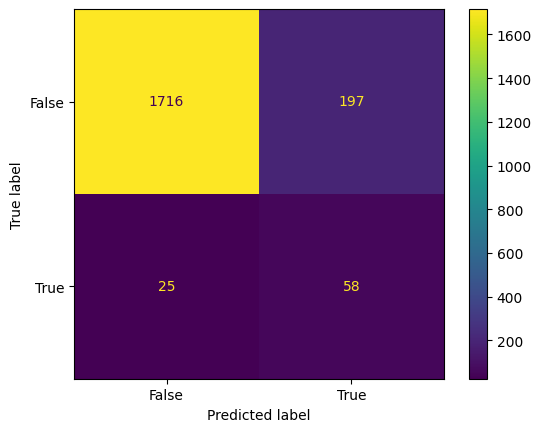

In [40]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);


In [41]:
# generate classification report
class_report = classification_report(y_test, model.predict(X_test))
print(class_report)

              precision    recall  f1-score   support

       False       0.99      0.90      0.94      1913
        True       0.23      0.70      0.34        83

    accuracy                           0.89      1996
   macro avg       0.61      0.80      0.64      1996
weighted avg       0.95      0.89      0.91      1996



## Communication

### Feature Importance

Text(0.5, 1.0, 'Feature Importance')

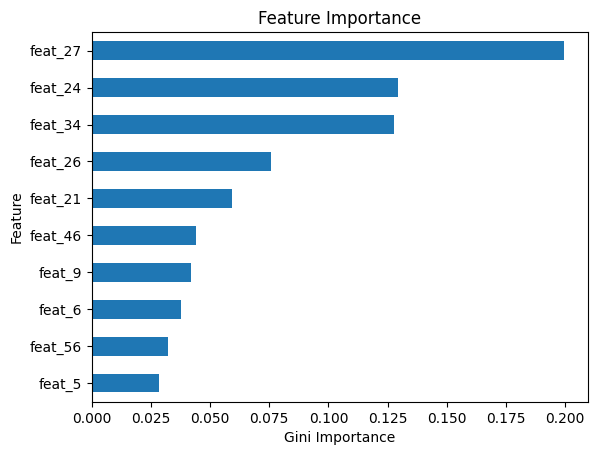

In [42]:
# Get feature names from training data
features = X_train.columns
# Extract importances from model
importances = model.best_estimator_.named_steps['gradientboostingclassifier'].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")

### Save Model

In [43]:
# Save model
with open("final_model.pkl", 'wb') as f:
    pickle.dump(model, f)

### Load Model

In [44]:
# Load `"model-1.pkl"`
with open("final_model.pkl","rb") as f:
    loaded_model = pickle.load(f)
print(loaded_model)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(10, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)
